In [1]:
%cd "../"

/workspace/MY-REPO/accelerated-performance


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import onnxruntime as ort
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from networks.UNet_plusplus.UNet_plusplus import UNet_plusplus

### Convert

In [3]:
# Trained model
model = torch.load("TorchModels/model2.pth")
input = torch.rand(3, 1, 128, 128).to(torch.float32).cuda()
output = model(input)

In [4]:
# convert
torch.onnx.export(model, input, "OnnxModels/onnx_model4.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

### Inference

In [ ]:
import tensorrt
print(tensorrt.__version__)

In [ ]:
tensorrt.__file__

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:456 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(onnxruntime::python::PySessionOptions&, const ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using [('TensorrtExecutionProvider', {'device_id': 0, 'trt_max_workspace_size': 2147483648, 'trt_fp16_enable': True, 'trt_engine_cache_enable': True, 'trt_engine_cache_path': 'Engine/onnx_model_sim_engine_2', 'trt_engine_hw_compatible': True}), ('CUDAExecutionProvider', {})]
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************


2024-06-08 07:04:53.484921718 [E:onnxruntime:Default, provider_bridge_ort.cc:1730 TryGetProviderInfo_TensorRT] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libcudnn.so.8: cannot open shared object file: No such file or directory

2024-06-08 07:04:53.627444352 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-06-08 07:04:53.627470927 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:870 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please re

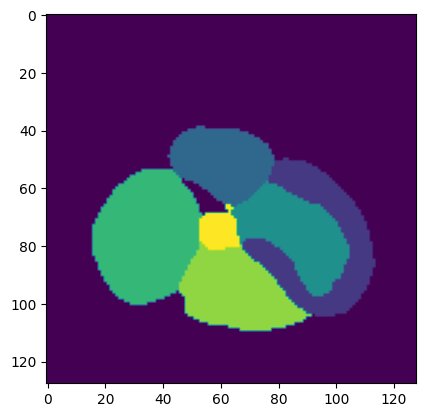

In [3]:
# Input and preprocessing
image = np.load('samples/0001_0170.npy')
img_size = 128
x, y = image.shape
if x != img_size and y != img_size:
    inputs = zoom(image, (img_size / x, img_size / y), order=0)
    
inputs = inputs[np.newaxis,np.newaxis,:,:]
inputs = np.float16(inputs)

# Inference
providers = [
    ('TensorrtExecutionProvider', {
        'device_id': 0,                       # Select GPU to execute
        'trt_max_workspace_size': 2147483648, # Set GPU memory usage limit
        'trt_fp16_enable': True,              # Enable FP16 precision for faster inference  
        'trt_engine_cache_enable': True,
        'trt_engine_cache_path': 'Engine/onnx_model_sim_engine_2',
        'trt_engine_hw_compatible' : True
    }),
    ('CUDAExecutionProvider', {
    })
]

ort_session = ort.InferenceSession("OnnxModels/onnx_model_sim2.onnx", providers=providers)
inp = {ort_session.get_inputs()[0].name: inputs}
out = ort_session.run(None, inp)

out = np.argmax(out[0], axis=1)
plt.imshow(out[0])
plt.show()

In [10]:
import torch

print(torch.cuda.is_available())

True


In [11]:
import onnxruntime

print(onnxruntime.__version__)

1.18.0
